## Задание 1

Какова вероятность отправиться на прогулку, если идёт дождь, при наличии следующих наблюдений?

```
data = [
        ('солнечно', True),
        ('снег', False),
        ('облачно', False),
        ('дождь', False),
        ('солнечно', True),
        ('снег', False),
        ('облачно', True),
        ('снег', False),
        ('солнечно', False),
        ('облачно', True),
        ('снег', True),
        ('солнечно', True),
        ('дождь', False),
        ('дождь', True),
        ('облачно', True),
]

***Решение:***

1) Рассмотрим следующие гипотезы:

    1. $H_1 =$ человек *отправится на прогулку*;

    2. $H_2 =$ человек *не отправится на прогулку*.

    Данные гипотезы образуют полную группу.

2) Вероятность возникновения гипотез (априорная вероятность гипотез $H_i, i = \overline{1, 2}$):

    1. $P(H_1) = \frac{8}{15}$;
    
    2. $P(H_2) = \frac{7}{15}$.

    Проверка: $\sum\limits_{i=1}^2 P(H_i) = 1$

3) Пусть зависимое событие $A$ – пойдет дождь. Оно может наступить, если наступит одна из гипотез $H_i, i = \overline{1, 2}$. Вероятность дождя при наступлении гипотезы $H_i$:

    1. при $i = 1: P(A|H_1) = \frac{1}{8}$;

    2. при $i = 2: P(A|H_2) = \frac{2}{7}$.

4) Значит, полная вероятность события $A$ равна: $P(A) = \sum\limits_{i=1}^2 P(H_i) \cdot P(A|H_i) = \frac{8}{15} \cdot \frac{1}{8} + \frac{7}{15} \cdot \frac{2}{7} = \frac{1}{5}$.

5) Получается, по формулам Байеса, пойти на прогулку при наступлении дождя: $P(H_2|A) = \frac{P(H_2) \cdot P(A|H_2)}{P(A)} = \frac{1}{3}$.


## Задание 2

- загрузите датасет для регрессии, проведите предобработку, выделите целевой признак и предикторы, разбейте данные на обучающую и тестовую выборку;
- Масштабируйте числовые признаки
- В случае дисбаланса проведите балансировку
- решите задачу классификации на ваших данных с использованием рассмотренных моделей sklearn: knn, NB, Logistic Regression, SVM. Не забудьте подобрать гиперпараметры.
- вычислите значения метрик Accuracy, Precision, Recall, F1, ROC AUC score

In [1]:
from pathlib import Path
import os
import sys

sys.path.append(str(Path(os.getcwd()).parent))

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [3]:
def draw_roc(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)

    display = RocCurveDisplay(
        fpr=fpr, 
        tpr=tpr, 
        roc_auc=roc_auc
    )

    display.plot()

    plt.show()

In [4]:
table = pd.read_csv("../data/neo_task.csv")
table.head(5)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3561024.0,(2011 GZ2),0.016016,0.035813,56014.078517,1.024333e+06,26.1,False
1,54016766.0,(2020 HT6),0.030518,0.068240,7864.348060,3.268186e+07,24.7,False
2,3746620.0,(2016 ED156),0.055533,0.124177,55257.544508,6.538636e+07,23.4,False
3,3633054.0,(2013 FD8),0.019256,0.043057,41531.404722,1.260796e+07,25.7,False
4,3742124.0,(2016 CW31),0.139494,0.311918,67639.394481,7.130590e+07,21.4,False


In [5]:
table.drop(columns=['id', 'name'], axis=1, inplace=True)
table.head(5)

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,0.016016,0.035813,56014.078517,1.024333e+06,26.1,False
1,0.030518,0.068240,7864.348060,3.268186e+07,24.7,False
2,0.055533,0.124177,55257.544508,6.538636e+07,23.4,False
3,0.019256,0.043057,41531.404722,1.260796e+07,25.7,False
4,0.139494,0.311918,67639.394481,7.130590e+07,21.4,False


In [6]:
null_columns = []
for i in table.columns:
    if len(table[table[i].isnull()]) > 0:
        null_columns.append(i)
print(null_columns)

['est_diameter_max', 'relative_velocity', 'absolute_magnitude']


In [7]:
def fill_empty_cell(column_name, df):
    if df.dtypes[column_name] == "float64":
        df[column_name] = df[column_name].fillna(df[column_name].mean())
    elif df.dtypes[column_name] == "int64":
        df[column_name] = df[column_name].fillna(df[column_name].median())
    else:
        df[column_name] = df[column_name].fillna(df[column_name].mode())


for name in null_columns:
    fill_empty_cell(name, table)

In [8]:
for i in table.columns:
    if len(table[table[i].isnull()]) > 0:
        print(f"В столбце {i} есть пустые элементы")

In [9]:
table.to_csv('../data/neo_task_compleated.csv', index=False) 

In [10]:
table.groupby(['hazardous'])['hazardous'].count()
# дисбаланс классов явно присутствует!!!

hazardous
False    81996
True      8840
Name: hazardous, dtype: int64

In [11]:
X = np.array(table.drop(columns=['hazardous'], axis=1))
y = np.array(table['hazardous'])

In [12]:
# масштабирование столбиков (очень большой разлет значений)
means, stds = X.mean(axis=0), X.std(axis=0)
X = (X - means) / stds
print(X[:3])


[[-0.37324117 -0.37376222  0.31519076 -1.61248863  0.8925783 ]
 [-0.32466019 -0.32510641 -1.59424649 -0.19616596  0.40698129]
 [-0.24085864 -0.24117577  0.28518947  1.26699715 -0.04393023]]


In [13]:
# решение проблемы дисбаланса классов (без этого негативные результаты в предсказывании класса объектов, представляющих опасность)
smt = SMOTE()
X, y = smt.fit_resample(X, y)
print(X.shape, y.shape)

(163992, 5) (163992,)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True)

**1. Метод k-ближайших соседей + метрики**

              precision    recall  f1-score   support

       False       0.99      0.84      0.91     24599
        True       0.86      0.99      0.92     24599

    accuracy                           0.92     49198
   macro avg       0.93      0.92      0.92     49198
weighted avg       0.93      0.92      0.92     49198



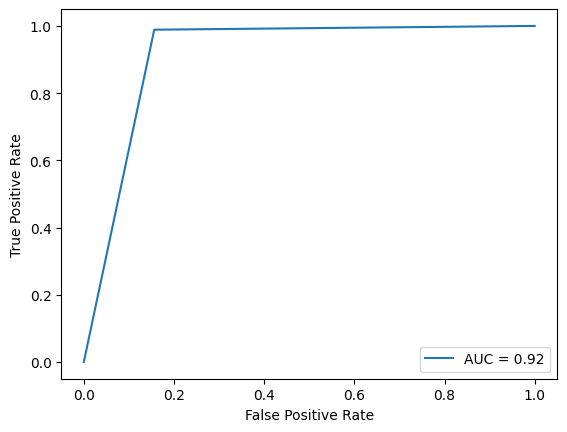

In [15]:
knn_params = {
    'n_neighbors': np.arange(5, 11, 2),
    'p': np.array([1, 2])
}

knn = GridSearchCV(KNeighborsClassifier(metric='minkowski'), knn_params).fit(X_train, y_train)
y_pred = knn.predict(X_test)

print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

In [16]:
knn.best_params_

{'n_neighbors': 5, 'p': 1}

**2. Наивный Байесовский классификатор + метрики**

              precision    recall  f1-score   support

       False       0.89      0.76      0.82     24599
        True       0.79      0.91      0.84     24599

    accuracy                           0.83     49198
   macro avg       0.84      0.83      0.83     49198
weighted avg       0.84      0.83      0.83     49198



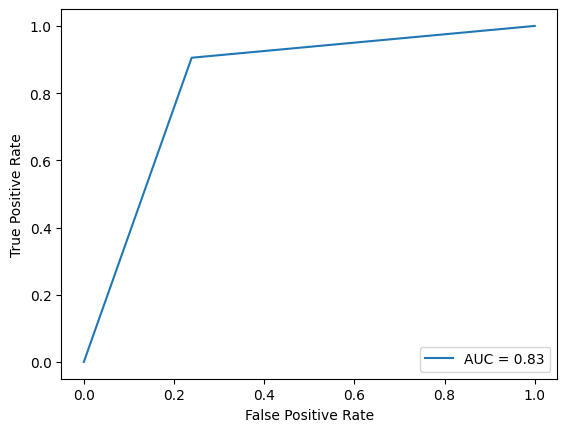

In [17]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

**3. Логистическая регрессия + метрики**

              precision    recall  f1-score   support

       False       0.92      0.77      0.84     24599
        True       0.80      0.93      0.86     24599

    accuracy                           0.85     49198
   macro avg       0.86      0.85      0.85     49198
weighted avg       0.86      0.85      0.85     49198



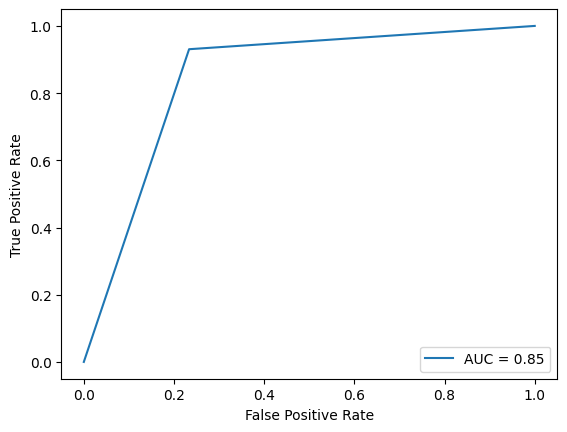

In [18]:
log_reg_params = {
    'C': np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10])
}

clf = GridSearchCV(LogisticRegression(), log_reg_params).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

In [19]:
clf.best_params_

{'C': 0.01}

              precision    recall  f1-score   support

       False       0.91      0.77      0.83     24599
        True       0.80      0.93      0.86     24599

    accuracy                           0.85     49198
   macro avg       0.86      0.85      0.85     49198
weighted avg       0.86      0.85      0.85     49198



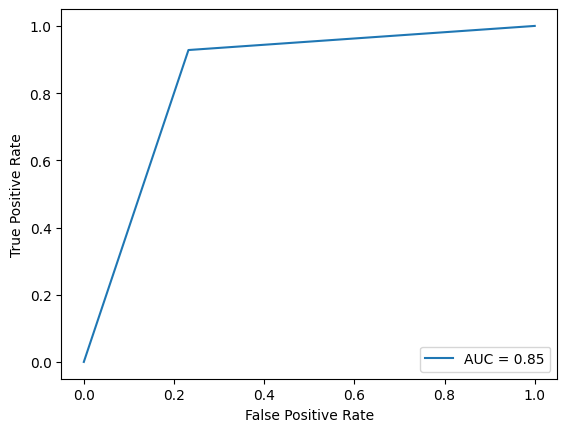

In [20]:
clf_L1 = LogisticRegression(penalty='l1', solver='liblinear').fit(X_train, y_train)
y_pred = clf_L1.predict(X_test)
print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

**4. Машина опорных векторов + метрики**

              precision    recall  f1-score   support

       False       0.99      0.72      0.84      2582
        True       0.77      0.99      0.87      2418

    accuracy                           0.85      5000
   macro avg       0.88      0.86      0.85      5000
weighted avg       0.89      0.85      0.85      5000



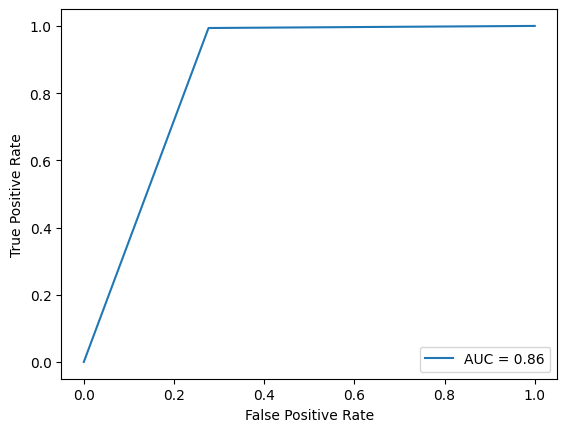

In [21]:
svc_params = {
    'C': np.array([0.01, 0.05, 0.1, 0.5, 1, 5, 10])
}

svc = GridSearchCV(SVC(), svc_params).fit(X_train[:5000], y_train[:5000])
y_pred = svc.predict(X_test[:5000])

print(classification_report(y_test[:5000], y_pred[:5000]))
draw_roc(y_test[:5000], y_pred[:5000])

In [22]:
svc.best_params_

{'C': 10.0}

## Задание 3
* Самостоятельно реализуйте метрики Accuracy, Precision, Recall, F1
* Самостоятельно реализуйте kNN и Naive Bayes

In [23]:
knn = KNeighborsClassifier(n_neighbors=7, metric='minkowski', p=2).fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.83      0.90     24599
        True       0.85      0.99      0.92     24599

    accuracy                           0.91     49198
   macro avg       0.92      0.91      0.91     49198
weighted avg       0.92      0.91      0.91     49198



In [24]:
from mylib.classification.Metrics import ClassificationMetrics


ClassificationMetrics(y_test, y_pred).report()

c:\Users\bugae\MachineLearning-Labs\mylib\classification\Metrics.py:52: RuntimeWarning: divide by zero encountered in divide
  return acc / self.y_true


,class_name,precision,recall,f1-score,accuracy
0,False,0.99,0.83,0.9,[]
1,True,0.85,0.99,0.91,[[44712. 44712. 44712. ... inf inf 44712.]]


c:\Users\bugae\MachineLearning-Labs\mylib\classification\KNN.py:36: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  answer.append(np.around(mode(choise)[0][0]))


              precision    recall  f1-score   support

       False       0.94      0.72      0.81      1034
        True       0.76      0.95      0.84       966

    accuracy                           0.83      2000
   macro avg       0.85      0.83      0.83      2000
weighted avg       0.85      0.83      0.83      2000



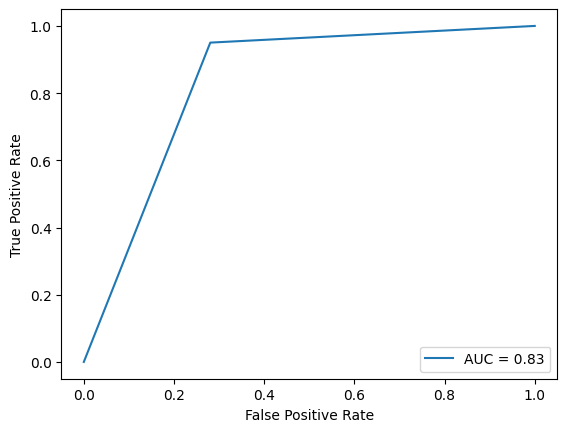

In [25]:
from mylib.classification.KNN import MyKNN

knn = MyKNN().fit(X_train[:2000], y_train[:2000])
y_pred = knn.predict(X_test[:2000])

print(classification_report(y_test[:2000], y_pred))
draw_roc(y_test[:2000], y_pred)

              precision    recall  f1-score   support

       False       0.89      0.76      0.82     24599
        True       0.79      0.91      0.84     24599

    accuracy                           0.83     49198
   macro avg       0.84      0.83      0.83     49198
weighted avg       0.84      0.83      0.83     49198



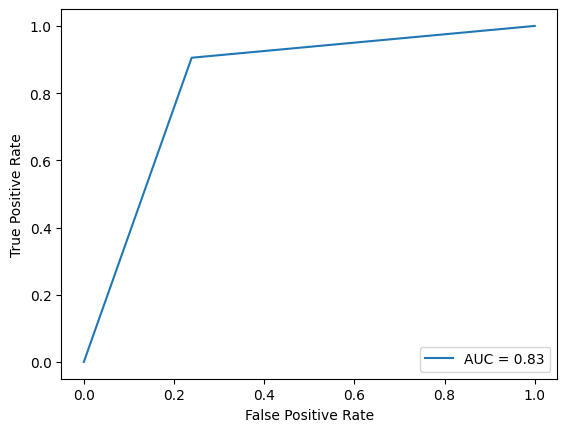

In [26]:
gnb = GaussianNB().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

              precision    recall  f1-score   support

       False       0.68      0.84      0.75     24599
        True       0.79      0.60      0.68     24599

    accuracy                           0.72     49198
   macro avg       0.73      0.72      0.72     49198
weighted avg       0.73      0.72      0.72     49198



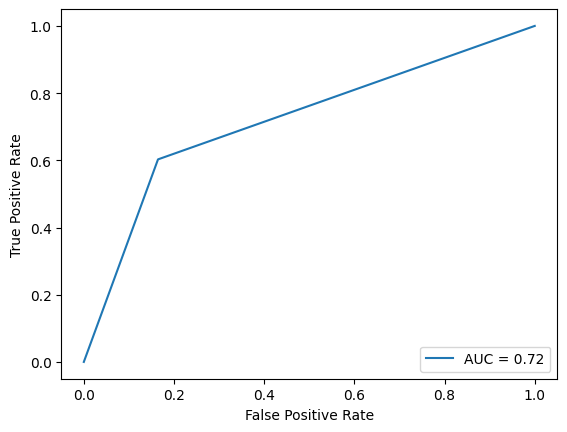

In [27]:
from mylib.classification.NaiveBayesСlassifier import MyNaiveBayesClassifer

gnb = MyNaiveBayesClassifer().fit(X_train, y_train)
y_pred = gnb.predict(X_test)

print(classification_report(y_test, y_pred))
draw_roc(y_test, y_pred)

## Дополнительные баллы

* Самостоятельно реализуйте SVM с возможностью выбирать ядро.

In [28]:
# skip